In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import beta
from matplotlib import pyplot as plt

# Probability of sharing distribution

We use the 2016 US elections dataset in "*Balancing Information Exposure in Social Networks*" to study the distribution of sharing probabilities.

## Description of the model and the data

They consider two groups, $A$ and $B$, and two campaigns (which are roughly equivalent to our articles $a$ and $b$).

Articles $a$ and $b$ propagate independently of each other: $u_2$ shares article $a$ with probability $p_A$, given that $u_1$ shared it. Analogously, $u_2$ shares article $b$ it with probability $p_B$, given that $u_1$ shared it.

They model the spread of information with a graph where a subset of the nodes are seeded with the information.

In this dataset, the graph is the Twitter's follower graph (an edge conveys that $u_2$ follows $u_1$). The dataset also contains the probabilities $p_A$ and $p_B$.

We only know the group for the seeds in the graph.

In [2]:
# load seeds
A = [l.strip() for l in open("side1_seeds.txt").readlines()]  # A = pro Hillary
B = [l.strip() for l in open("side2_seeds.txt").readlines()]  # B = pro Trump
len(A), len(B)

(85, 99)

In [53]:
# load probabilities
df = pd.read_csv("uselections_network_heterogeneous.txt", sep='\t', names=['User1', 'User2', 'pA', 'pB'])
df2 = pd.read_csv("uselections_network_correlated.txt", sep='\t', names=['User1', 'User2', 'p'])
df

,User1,User2,pA,pB
0,003a04f8c2054b7,birdonachair,0.000834,0.008674
1,003a04f8c2054b7,patriot18d,0.001160,0.003320
2,003a04f8c2054b7,pamela_moore13,0.000143,0.004143
3,003a04f8c2054b7,jbaker31826004,0.000604,0.015884
4,003a04f8c2054b7,glucklichschon,0.001960,0.019880
...,...,...,...,...
845147,healthyyoga07,rickrwells,0.000250,0.010810
845148,healthyyoga07,supercos7,0.004560,0.015920
845149,healthyyoga07,ladiesfortrump,0.001448,0.032888
845150,healthyyoga07,usa_with_trump,0.001067,0.016427


In [73]:
df2.sort_values(['User2'], ascending=True)

,User1,User2,p
727727,hippygirl37,003a04f8c2054b7,0.001695
383621,totemranch613,003a04f8c2054b7,0.001695
802145,joydcarter,003a04f8c2054b7,0.001695
746512,irshroz,003a04f8c2054b7,0.001695
383953,tovaod,003a04f8c2054b7,0.001695
...,...,...,...
737489,i_amamerica,zz201,0.003030
351280,tbobrewdog,zz201,0.003030
226888,realtybird,zzelda01,0.014286
155146,mobygrapefan,zzelda01,0.014286


## Homophily

We measure homophily by estimating the probabilities that a user that belongs to group $g$ follows a user in group $g'$. This is very close to our replacement model because if User1 shares content, it gives the opportunity to User2 to retweet the content.

To estimate these probabilities we just count the number of edges for each combination of groups and calculate group frequencies.

In [4]:
# membership
labeled = df[(df.User1.isin(A) | df.User1.isin(B)) & (df.User2.isin(A) | df.User2.isin(B))].copy()
labeled['Group1'] = labeled.User1.isin(A).replace({True: 'A', False: 'B'})
labeled['Group2'] = labeled.User2.isin(A).replace({True: 'A', False: 'B'})
labeled.head()

,User1,User2,pA,pB,Group1,Group2
3282,1boxingking1,georgemason101,0.003017,0.082857,B,B
6861,20donaldtrump16,azz_amis,0.006907,0.086667,B,B
6865,20donaldtrump16,tukinovf,0.002937,0.082857,B,B
6870,20donaldtrump16,ronyerby,0.004160,0.084000,B,B
11871,6f1abe900f56450,honey17011,0.065718,0.000518,A,A


In [5]:
# replacement counts
replacements = (labeled.groupby(['Group1', 'Group2']).User1
                       .count()
                       .unstack(fill_value=0)
                       .stack()
                       .rename('Counts')
                       .reset_index()
                       .set_index(['Group1', 'Group2']))
replacements

Counts
Group1 Group2        
A      A          323
       B            4
B      A            0
       B          263

In [6]:
# group1 counts
groups = (labeled.groupby('Group1').User1
                 .count()
                 .rename('Counts')
                 .reset_index()
                 .set_index('Group1'))
groups

,Counts
Group1,
A,327
B,263


In [45]:
qs = (replacements / groups).rename(columns={'Counts': 'Frequency'})
qs

Frequency
Group1 Group2           
A      A        0.987768
       B        0.012232
B      A        0.000000
       B        1.000000

The following is the the homophily matrix (coordinates are the $q_A$, $1-q_A$, and 1- $q_B$, $q_B$ probabilities):

In [8]:
qs.unstack().values

array([[0.98776758, 0.01223242],
       [0.        , 1.        ]])

## Share probability distributions


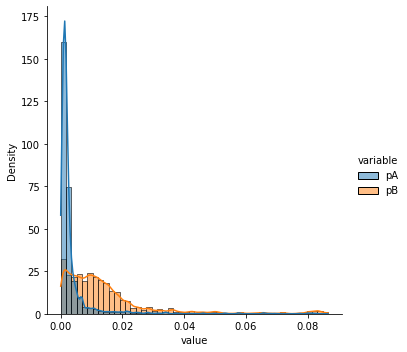

In [9]:
sns.displot(data=pd.melt(df,
                         id_vars=['User1', 'User2'],
                         value_vars=['pA', 'pB']),
            x='value',
            hue='variable',
            bins=50, kde=True, stat='density')

The pro-Trump distribution ($p_B$) is less skewed, meaning that pro-Trump tweets are more likely to be retweeted.

Since this is a distribution of probabilities, it should have support on $[0,1]$. A beta distribution may be a good choice to fit the data.

In [10]:
# MLE estimates for the parameters of the beta distribution (for p_A)
a1, b1, loc1, scale1 = beta.fit(df.pA, floc=0, fscale=1)
a1, b1

(0.7961640748261505, 222.62377495491623)

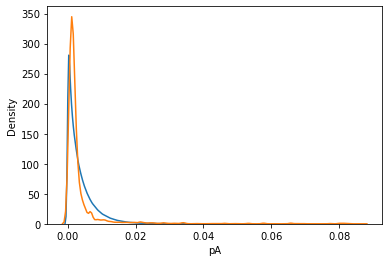

In [11]:
sns.kdeplot(np.random.beta(a=a1, b=b1, size=df.pA.shape[0]))
sns.kdeplot(df.pA)

In [12]:
# MLE estimates for the parameters of the beta distribution (for p_B)
a2, b2, loc2, scale2 = beta.fit(df.pB, floc=0, fscale=1)
a2, b2

(1.0402128477517107, 71.47304220053908)

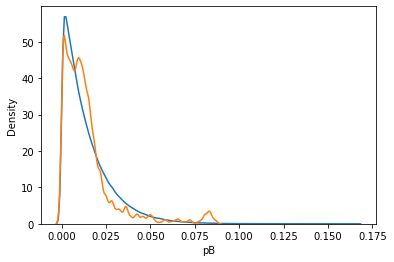

In [13]:
sns.kdeplot(np.random.beta(a=a2, b=b2, size=df.pB.shape[0]))
sns.kdeplot(df.pB)

The probabilities above are the conditional probabilities on a given initiator. In the data we see that the probability of sharing is independent of the initiator. That's strange because, in practice, since reputation and credibility are important factors for sharing someone else's tweet.

In [52]:
df.sort_values(by='User2').tail(n=50)

,User1,User2,pA,pB
553415,coffey_arthur,znatrainer,0.000417,0.000417
814301,k_eckrich,zocchyzd1953,0.004000,0.004000
199703,pmicc33,zocchyzd1953,0.004000,0.004000
498554,bravehart60,zocchyzd1953,0.004000,0.004000
554702,colleengourd,zodiactank,0.004000,0.004000
55492,lbljm1,zodiactank,0.004000,0.004000
663064,beachdreamin291,zodiactank,0.004000,0.004000
682220,geonna42,zolemica2,0.006667,0.006667
105469,march4progress,zombieninja420,0.001250,0.001250
549878,cleo_peterson,zonja47405,0.001429,0.001429


## Different groups

Ideally, we would like to study the distributions of $p_{A, s}$ and $p_{B, s}$ for $s\in\{a,b\}$ and not just the marginal probabilities $p_{*, a}$ and $p_{*,b}$ (which are the probabilities of clicking on the articles regardless of group membership).

In [16]:
dfg = df[df.User2.isin(B) | df.User2.isin(A)]  # we just care about the group of the user who is retweeting

In [17]:
group = dfg.User2.isin(A).replace({True: 'A', False: 'B'})

In [18]:
dfg.groupby(group).User2.count()

User2
A    6692
B    8765
Name: User2, dtype: int64

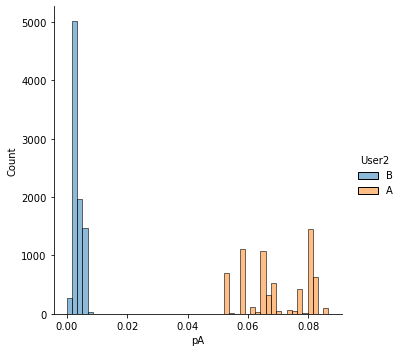

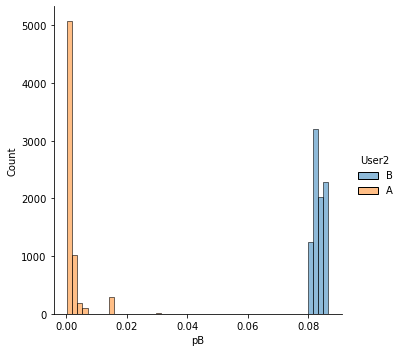

In [19]:
sns.displot(data=dfg, x='pA', hue=group, bins=50)
sns.displot(data=dfg, x='pB', hue=group, bins=50)

This symmetry makes sense because the probability of sharing the article that agrees with the group's views is higher than otherwise.

## MLE estimates for the parameters of a beta that fits the distrib of $p_{A,a}$

In [20]:
# MLE estimates for the parameters of the beta distribution (for $p_{A,a}$)
a1, b1, loc1, scale1 = beta.fit(dfg[group == 'A'].pA, floc=0, fscale=1)
a1, b1

(41.45784070052453, 556.8653671739492)

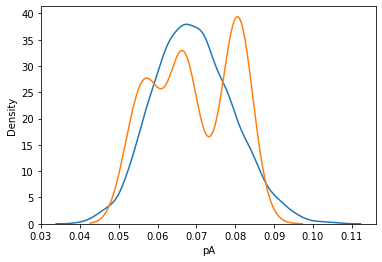

In [21]:
sns.kdeplot(np.random.beta(a=a1, b=b1, size=dfg[group == 'A'].pA.shape[0]))
sns.kdeplot(dfg[group == 'A'].pA, bw_adjust=2)

## MLE estimates for the parameters of beta that fits the distrib of $p_{A,b}$

In [22]:
a2, b2, loc2, scale2 = beta.fit(dfg[group == 'A'].pB, floc=0, fscale=1)
a2, b2

(0.7519296311195025, 413.4664888783973)

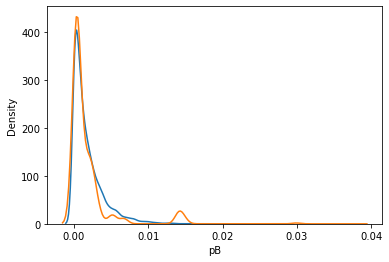

In [23]:
sns.kdeplot(np.random.beta(a=a2, b=b2, size=dfg[group == 'A'].pB.shape[0]))
sns.kdeplot(dfg[group == 'A'].pB)

## MLE estimates for the parameters of beta to fit the distrib of $p_{B,a}$

In [24]:
a3, b3, loc3, scale3 = beta.fit(dfg[group == 'B'].pA, floc=0, fscale=1)
a3, b3

(6.096475779403813, 1519.8459882514462)

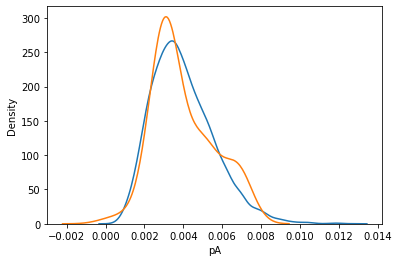

In [25]:
sns.kdeplot(np.random.beta(a=a3, b=b3, size=dfg[group == 'B'].pA.shape[0]))
sns.kdeplot(dfg[group == 'B'].pA, bw_adjust=3)

## MLE estimates for the parameters of beta to fit the distrib of $p_{B,b}$

In [26]:
a4, b4, loc4, scale4 = beta.fit(dfg[group == 'B'].pB, floc=0, fscale=1)
a4, b4

(2152.960173995409, 23647.671142918956)

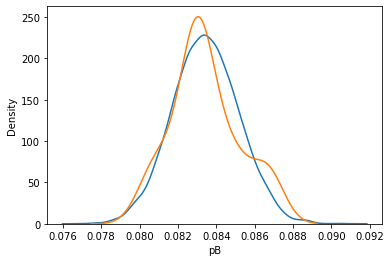

In [27]:
sns.kdeplot(np.random.beta(a=a4, b=b4, size=dfg[group == 'B'].pB.shape[0]))
sns.kdeplot(dfg[group == 'B'].pB, bw_adjust=3)

In [28]:
# TODO: perhaps we should perform some goodness-of-fit tests